Performing a gradient attack, converting it into a model attack, then into a data attack

# HOW TO USE (on google colab)

- This code uses a pretrained model from this repo : https://github.com/huyvnphan/PyTorch_CIFAR10
- You have to clone the repo on your google drive in a folder named "cifar10" such that you have the following tree : "My Drive/cifar10/PyTorch_CIFAR10/train.py"
- You also have to manually upload and unzip the model weights from the repo (https://drive.google.com/file/d/17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq/view?usp=sharing) into "My Drive/cifar10/PyTorch_CIFAR10/cifar10_models/state_dicts/" such that you have : "My Drive/cifar10/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg13_bn.pt"
- Finally run all cells, the only action needed is to link your google drive to google colab on cell 2

# INITIALISATION

In [ ]:
from time import time
import os
import shutil
import random
from copy import deepcopy
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image, resize, to_tensor

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# To link your google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/cifar10/PyTorch_CIFAR10
from cifar10_models.vgg import vgg13_bn 

# Pretrained model
my_model = vgg13_bn(pretrained=True)

/content/drive/My Drive/cifar10/PyTorch_CIFAR10


In [ ]:
DEFAULTS = {
    "w": 1,   # float >= 0, harmonisation parameter
    "lr_gen": 0.02,     # float > 0, learning rate of global model
    "lr_node": 0.02,    # float > 0, learning rate of local models
    "NN" : 'linear',     # "linear" or "2layers", neural network architecture
    "opt": optim.Adam,    # any torch optimizer
    "pow_gen": (2, 1),  # generalisation norm  
}

METRICS = {
    'fit': {"lab":"fit", "ord": "Training Loss", "f_name": "loss"},
    'gen': {"lab":"gen", "ord": "Training Loss", "f_name": "loss"},
    'acc_loc': {"lab":"acc_loc", "ord": "Accuracy", "f_name": "acc"},
    'acc_glob': {"lab":"acc_glob", "ord": "Accuracy", "f_name": "acc"},
    'honest_dist': {"lab":"honest_dist", "ord": "l2 norm", "f_name": "l2dist"},
    'l2_norm': {"lab":"l2_norm", "ord": "l2 norm", "f_name": "l2dist"},
    'target_dist': {"lab":"target_dist", "ord": "l2 norm", "f_name": "l2dist"},
    'grad_norm': {"lab":"grad_norm", "ord": "Scalar Product", "f_name": "grad"},
    'attack_dist': {"lab":"attack_dist", "ord": "l2 norm", "f_name": "l2dist"},
    'grad_loc': {"lab":"grad_loc", "ord": "l2 norm", "f_name": "grad_loc"},
    'scal_p': {"lab":"scal_p", "ord": "scalar", "f_name": "scal_p"},
}

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [ ]:
os.chdir("/content")
os.makedirs("distribution", exist_ok=True)
os.chdir("/content/distribution")

# DATA

In [ ]:
# data hyperparameters

DATASET = datasets.CIFAR10
IMG_SIZE = 32
NOISE = 0
CATS = list(range(10))

## functions

In [ ]:
# data import and management

def load_mnist(img_size=IMG_SIZE, noise=NOISE, cats=CATS):
    """ return data and labels for train and test mnist dataset """
    normalize = transforms.Normalize( 
        mean = [0.4914, 0.4822, 0.4465],                        
        std = [0.2471, 0.2435, 0.2616]
    )
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    #---------------- train data -------------------
    mnist_train = DATASET('data', train=True, download=True)#, transform=transform)
    data_train = mnist_train.data
    labels_train = [mnist_train[i][1] for i in range(len(data_train)) if mnist_train[i][1] in cats]

    pics = []
    for pic, lab in zip(data_train, mnist_train):
        if lab[1] in cats:
            pic = to_pil_image(pic)
            if img_size != 32:
                pic = resize(pic, img_size) # Resize image if needed
            pic = to_tensor(pic)            # Tensor conversion normalizes in [0,1]
            pics.append(pic)
    data_train = torch.stack(pics)

    #------------------  test data -----------------------
    mnist_test = DATASET('data', train=False, download=True)#, transform=transform)
    data_test = mnist_test.data
    labels_test = [mnist_test[i][1] for i in range(len(data_test)) if mnist_test[i][1] in cats]

    pics = []
    for pic, lab in zip(data_test, mnist_train):
        if lab[1] in cats:
            pic = to_pil_image(pic)
            if img_size != 32:
                pic = resize(pic, img_size) # Resize image if needed
            pic = to_tensor(pic)            # Tensor conversion normalizes in [0,1]
            pics.append(pic)
    data_test = torch.stack(pics)

    nb_rd = int(len(labels_train) * noise)  # number of random labels
    for i in range(nb_rd):
        labels_train[i] = random.randint(0, 9)
    return (data_train, labels_train), (data_test,labels_test)

def query(datafull, nb, bias=0, fav=0):
    """ return -nb random samples of -datafull """
    data, labels = datafull
    idxs = list(range(len(data)))
    l = []
    h, w = data[0][0].shape
    d = torch.empty(nb, 1, h, w)
    if bias == 0:
        indexes = random.sample(idxs, nb) # drawing nb random indexes
    else :
        indexes = []
        for i in range(nb):
            idx = one_query(labels, idxs, bias, fav)
            indexes.append(idx)
            idxs.remove(idx) # to draw only once each index max
    for k, i in enumerate(indexes): # filling our query
        d[k] = data[i]
        l.append(labels[i])
    return d, l

def one_query(labels, idxs, redraws, fav):
    """ labels : list of labels
        idxs : list of available indexes
        draws an index with a favorite label choice 
        fav : favorite label
        redraws : max nb of random redraws while fav not found
    """
    lab = -1 
    while lab != fav and redraws >= 0:
        idx = idxs[random.randint(0, len(idxs)-1)]
        lab = labels[idx]
        redraws -= 1
    return idx

def list_to_longtens(l):
    """ change a list into the appropriate ground truths type """
    probas_gt = not (type(l[0]) is int or l[0].shape == 0)
    if probas_gt:
        tens = torch.empty((len(l), 10))
    else:
        tens = torch.empty(len(l), dtype=torch.long)
    for i, lab in enumerate(l): 
        tens[i] = lab
    return tens

def swap(l, n, m):
    """ swap n and m values in l list """
    return [m if (v==n) else n if (v==m) else v for v in l]

def distribute_data_rd(datafull, distrib, fav_lab=(0,0), 
                       dish=False, dish_lab=0, gpu=True): 
    """draw random data on N nodes following distrib
        data, labels : raw data and labels
        distrib : int list, list of nb of data points for each node
        pref_lab : (prefered label, strength of preference (int))
        dish : boolean, if nodes are dishonest 
        dish_lab : 0 to 4, labelisation method

        returns : (list of batches of images, list of batches of labels)
    """
    data, labels = datafull
    N = len(distrib)
    data_dist = []      # list of len N
    labels_dist = []    # list of len N
    fav, strength = fav_lab

    for n, number in enumerate(distrib): #for each node
        d, l = query(datafull, number, strength, fav)
        if gpu:
            data_dist.append(torch.FloatTensor(d).cuda())
        else:
            data_dist.append(torch.FloatTensor(d))
        if dish:                # if dishonest node

            # labels modification
            if dish_lab == 0: # random
                tens = torch.randint(10, (number,), dtype=torch.long)
            elif dish_lab == 1: # zeros
                tens = torch.zeros(number, dtype=torch.long)
            elif dish_lab == 2: # "one_evil"
                l = swap(l, 1, 7)
                tens = list_to_longtens(l)
            elif dish_lab == 3: # "strats" , label 8 to 0  
                n, m = random.randint(0,9), random.randint(0,9)
                l = swap(l, n, m)
                tens = list_to_longtens(l)
            elif dish_lab == 4: # label +1, "jokers"
                tens = (list_to_longtens(l) + 1) % 10

        else:           # if honest node 
            tens = list_to_longtens(l) # needed for CrossEntropy later
        if gpu:
            tens = tens.cuda()

        labels_dist.append(tens)

    return data_dist, labels_dist

## get data

In [ ]:
# downloading data
if 'train' not in globals(): # to avoid loading data every time
    train_ims, test_ims = load_mnist()
    if torch.cuda.is_available():
        test_gpu_ims = torch.tensor(test_ims[0]).cuda(), torch.tensor(test_ims[1]).cuda()
        # test_gpu_biased = (test_gpu[0], (test_gpu[1] + 1) % 10)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

my_model.classifier[-1] = Identity()

In [ ]:
BATCH_SIZE =  1000
MULT = 50
NB_FEATS = my_model(test_ims[0][:1]).shape[1]
train = torch.empty((BATCH_SIZE * MULT , 1, 1, NB_FEATS)), train_ims[1][:BATCH_SIZE * MULT]

for i in range(MULT):
    train[0][i * BATCH_SIZE : (i+1) * BATCH_SIZE, 0, 0, :] = my_model(train_ims[0][i * BATCH_SIZE : (i+1) * BATCH_SIZE]).detach()
test_gpu = torch.reshape(my_model.cuda()(test_gpu_ims[0][0:1000]).detach(), (1000, 1, 1, NB_FEATS)), test_gpu_ims[1][000:1000]
test_gpu_biased = (test_gpu[0], (test_gpu[1] + 1) % 10)

# MODELS

In [ ]:
# model structure (2 options)

def get_base_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(NB_FEATS, 10),
        nn.LogSoftmax(dim=1),
        )
    if gpu:
        return model.cuda()
    return model

def get_2l_classifier(gpu=True):
    """ returns linear baseline classifier """
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(NB_FEATS, NB_FEATS),
        torch.nn.ReLU(),
        nn.Linear(NB_FEATS, 10),
        nn.LogSoftmax(dim=1),
        )
    if gpu:
        return model.cuda()
    return model

MODELS = {"linear": get_base_classifier, '2layers': get_2l_classifier}

# TRAINING STRUCTURE

## Losses

In [ ]:
# loss and scoring functions 

def local_loss(model_loc, x, y):  
    """ classification loss """
    # if ground truths are labels
    if y.dim() == 1:  
        loss_func = nn.NLLLoss(reduction='sum')
        # return loss_func(model_loc(x), y)
        a = loss_func(model_loc(x), y)
        return a

    # if ground truths are probabilities
    out = model_loc(x)
    loss = - torch.sum(y * out)
    return loss

def models_dist(model_loc, model_glob, pow=(2, 0.5)):  
    """ l1 distance between global and local parameter
        pow : (internal power, external power)
    """
    q, p = pow
    dist = sum(((theta - rho)**q).abs().sum() for theta, rho in 
                  zip(model_loc.parameters(), model_glob.parameters()))**p
    return dist

def model_norm(model_glob, pow=(2, 0.5)): 
    """ l2 squared regularisation of global parameter
     will be multiplied by w_0 
     pow : (internal power, external power)
     """
    q, p = pow
    norm = sum((param**q).abs().sum() for param in model_glob.parameters())**p
    return norm

def round_loss(tens, dec=0): 
    """from an input scalar tensor returns rounded integer"""
    if type(tens)==int or type(tens)==float:
        return round(tens, dec)
    else:
        return round(tens.item(), dec)

def tens_count(tens, val):
    """ counts nb of -val in tensor -tens """
    return len(tens) - round_loss(torch.count_nonzero(tens-val))

def score(model, datafull):
    """ returns accuracy provided models, images and GTs """
    out = model(datafull[0])
    predictions = torch.max(out, 1)[1]
    c=0
    for a, b in zip(predictions, datafull[1]):
        c += int(a==b)
    return c/len(datafull[0])


## Flower

### flower class

In [ ]:
# nodes repartition

class Flower():
    """ Training structure including local models and general one 
        Allowing to add and remove nodes at will
        .pop
        .add_nodes
        .rem_nodes
        .train
        .display
        .check
    """

    def __init__(self, test, 
                 target_vector=None, attack_vector=None, honest_vector=None,
                 gpu=True, **kwargs):
        """ 
            test : test data couple (imgs, labels)
            target_vector : model that the attacker wants to force 
                                as the global model 
        """
        self.d_test = test
        self.gpu = gpu

        self.opt = kwargs["opt"]
        self.lr_node = kwargs["lr_node"]
        self.lr_gen = kwargs["lr_gen"]

        self.get_classifier = MODELS[kwargs["NN"]]
        self.general_model = self.get_classifier(gpu)
        self.init_model = deepcopy(self.general_model)
        self.last_grad = None
        self.opt_gen = self.opt(self.general_model.parameters(), lr=self.lr_gen)
        self.pow_gen = kwargs["pow_gen"]  # choice of norms for Licchavi loss
        self.data = []
        self.labels = [] 
        self.typ = []
        self.models = []
        self.weights = []
        self.d_params = []  # huber loss parameters (1 for each node)
        self.age = []
        self.opt_nodes = []
        self.nb_nodes = 0
        self.dic = {"honest" : -1, "trolls" : 0, "zeros" : 1, 
                    "one_evil" : 2, "strats" : 3, "jokers" : 4, "byzantine" : -1,
                    'freezed' : -1}
        self.history = {key: [] for key in METRICS}
        # ("fit", "gen", "reg", "acc", "l2_dist", "l2_norm", "grad_sp", "grad_norm_glob", "attack_dist", "grad_norm_loc", scal_p)

        # FOR MALICIOUS NODE
        self.target_vector = target_vector  # target model
        self.attack_vector = attack_vector  # attacking model (for metric)
        self.honest_vector = honest_vector  # honest local vector (for metric)
        # last epoch sum of honest gradients
        self.last_honest_grads = [torch.tensor([0 for i in par]) 
                                    for par in self.general_model.parameters()] 

        # To add accuracy at epoch 0
        acc_glob = self.score_glob(self.d_test)
        self.history['acc_glob'].append(acc_glob)  

    # ------------ population methods --------------------
    def set_localtest(self, datafull, size, nodes, fav_lab=(0,0), typ="honest"):
        """ create a local data for some nodes
            datafull : source data
            size : size of test sample
            fav_labs : (label, strength)
            nodes : list of nodes which use this data           
        """
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size], fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        dtloc = (dt[0], lb[0])
        self.localtest[1].append(dtloc)
        id = len(self.localtest[1]) - 1
        for n in nodes:
            self.localtest[0][n] = id

    def add_nodes(self, datafull, pop, typ, fav_lab=(0,0), verb=1, **kwargs):
        """ add nodes to the Flower 
            datafull : data to put on node (sampled from it)
            pop : (nb of nodes, size of nodes)
            typ : type of nodes (str keywords)
            fav_lab : (favorite label, strength)
            w : int, weight of new nodes
        """
        w = kwargs["w"] # taking global variable if -w not provided
        nb, size = pop
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size] * nb, fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        self.data += dt
        self.labels += lb
        self.typ += [typ] * nb

        self.models += [self.get_classifier(self.gpu) for i in range(nb)]
        self.weights += [w] * nb
        self.age += [0] * nb
        self.d_params += [size**(-0.5)] * nb
        self.nb_nodes += nb
        self.opt_nodes += [self.opt(self.models[n].parameters(), lr=self.lr_node)
            for n in range(self.nb_nodes - nb, self.nb_nodes) 
            ]
        if verb:
            print("Added {} {} nodes of {} data points".format(nb, typ, size))
            print("Total number of nodes : {}".format(self.nb_nodes))

    def rem_nodes(self, first, last, verb=1):
        """ remove nodes of indexes -first (included) to -last (excluded) """
        nb = last - first
        if last > self.nb_nodes:
            print("-last is out of range, remove canceled")
        else:
            del self.data[first : last]
            del self.labels[first : last] 
            del self.typ[first : last]
            del self.models[first : last]
            del self.weights[first : last]
            del self.age[first : last]
            del self.opt_nodes[first : last]
            del self.d_params[first : last]
            del self.localtest[0][first : last]
            self.nb_nodes -= nb
            if verb: print("Removed {} nodes".format(nb))
        
    def hm(self, ty):
        """ count nb of nodes of this type """
        return self.typ.count(ty)
    
    def pop(self):
        """ return dictionnary of population """
        c = {}
        for ty in self.dic.keys():
            c[ty] = self.hm(ty)
        return c

    # ------------- scoring methods -----------
    def score_glob(self, datafull): 
        """ return accuracy provided images and GTs """
        return score(self.general_model, datafull)
    
    def score_loc(self, node):
        """ score of node on global test data """
        return score(self.models[node], self.d_test)

    def score_nodes(self, l_nodes):
        """ mean local test scores of nodes """
        score_tot = 0
        for node in l_nodes:
            score_tot += score(self.models[node], self.d_test)
        return score_tot / len(l_nodes)

    def test_train(self, node):
        """ score of node on its train data """
        return score(self.models[node], (self.data[node], self.labels[node]))

    def display(self, node):
        """ display accuracy for selected node
            node = -1 for global model
        """
        if node == -1: # global model
            print("global model")
            print("accuracy on test data :", 
                  self.score_glob(self.d_test))
        else: # we asked for a node
            loc_train = self.test_train(node)
            full_test = self.score_loc(node)
            print("node number :", node, ", dataset size :",
                len(self.labels[node]), ", type :", self.typ[node], 
                ", age :", self.age[node])
            print("accuracy on local train data :", loc_train)
            print("accuracy on global test data :", full_test)
            repart = {str(k) : tens_count(self.labels[node], k) 
                for k in range(10)}
            print("labels repartition :", repart)
    
    # ---------- methods for training ------------
    def _lr_schedule(self, schedule):
        """ changes learning rates during trainning """
        decay, lr_min = schedule
        if self.lr_node >= lr_min / decay:
            self.lr_node *= decay
            self.lr_gen *= decay

    def _set_lr(self):
        """set learning rates of optimizers according to Flower setting"""
        for n in range(self.nb_nodes):  # updating lr in optimizers
            # we freeze malicious models (for model attack only)
            if self.typ[n] == 'freezed':
                self.opt_nodes[n].param_groups[0]['lr'] = 0
            else:
                self.opt_nodes[n].param_groups[0]['lr'] = self.lr_node
        self.opt_gen.param_groups[0]['lr'] = self.lr_gen

    def _zero_opt(self):
        """reset gradients of all models"""
        for n in range(self.nb_nodes):
            self.opt_nodes[n].zero_grad()      
        self.opt_gen.zero_grad()

    def _update_hist(self, epoch, test_freq, fit, gen, verb=1):
        """ update history """
        acc_glob = self.score_glob(self.d_test)
        acc_loc = self.score_loc(0)

        self.history['fit'].append(round_loss(fit))
        self.history['gen'].append(round_loss(gen))
        self.history['acc_loc'].append(acc_loc) 
        self.history['acc_glob'].append(acc_glob) 

        norm = model_norm(self.general_model, pow=(2,0.5))
        self.history['l2_norm'].append(round_loss(norm, 1))

        self.history['grad_norm'].append(grad_norm(self.general_model))
        self.history['grad_loc'].append(grad_norm(self.models[0]))

        with torch.no_grad():
            dist = 0 if self.target_vector is None else models_dist(self.general_model, self.target_vector, (2, 0.5))
            self.history['target_dist'].append(
                round_loss(dist, 10)
            ) 

        with torch.no_grad():
            dist = 0 if self.attack_vector is None else models_dist(self.models[-1], self.attack_vector, (2, 0.5))
            self.history['attack_dist'].append(
                round_loss(dist, 10)
            ) 

        with torch.no_grad():
            dist = 0 if self.honest_vector is None else models_dist(self.models[0], self.honest_vector, (2, 0.5))
            self.history['honest_dist'].append(
                round_loss(dist, 10)
            )

        with torch.no_grad():
            if self.attack_vector is None:
                scal_p = 0
            else:
                scal_p = sum(torch.sum((glob - targ) * (att - targ)) for glob, targ, att in zip(
                    self.general_model.parameters(),
                    self.target_vector.parameters(),
                    self.attack_vector.parameters(),
                ))
            self.history['scal_p'].append(round_loss(scal_p, 10))

    def _old(self, years):
        """ increment age (after training) """
        for i in range(self.nb_nodes):
            self.age[i] += years
    
    def _do_all_step(self, freeze_global=False):
        for n in range(self.nb_nodes): 
            self.opt_nodes[n].step()
        if not freeze_global:
            self.opt_gen.step() 

    def _print_losses(self, tot, fit, gen):
        """print losses"""
        print("total loss : ", tot) 
        print("fitting : ", round_loss(fit),
              ', generalisation : ', round_loss(gen))
        
    def _counter_grad_attack(self):
        """ computes the CGA """

        def _attack(last_grad, lr, current, target):
            """ compute attacking gradient for one parameter 
            
            last_grad (float): gradient of last epoch
            lr (float): current lr
            current (float tensor): global model parameters
            target (float tensor): target model parameters
            """
            expected_result = current - last_grad * lr
            best_attack = (- target + expected_result) / lr
            return best_attack

        # computing attack
        with torch.no_grad():
            attack_grads = self.get_classifier(self.gpu)
            for attack, last_grad, current, target in zip(
                    attack_grads.parameters(), 
                    self.last_honest_grads,
                    # extract_grad(self.general_model),
                    self.general_model.parameters(),
                    self.target_vector.parameters()
                ):
                for i, (h_grad, curr, targ) in enumerate(zip(last_grad, current, target)):
                    attack[i] = _attack(h_grad, self.lr_gen, curr, targ)

            if self.pow_gen == (2, 0.5):  # if L_2 (not squared norm), attack limited
                attack_invnorm = 1 / model_norm(attack_grads, (2, 0.5))
                if attack_invnorm < 1 / self.weights[0]:  # if norm > w
                    for par in attack_grads.parameters():
                        for i, p in enumerate(par):
                            par[i] = p * attack_invnorm * self.weights[0]
        
        # saving honest grads for next epoch
        self.last_honest_grads = deepcopy(extract_grad(self.general_model))

        # applying attack
        for attack, param in zip(attack_grads.parameters(), self.general_model.parameters()):
            for i, att in enumerate(attack):
                param.grad[i] += att

    # ====================  TRAINING ================== 

    def train(
            self, nb_epochs=None, test_freq=1, verb=1, schedule=(1,0), 
            gradient_hacking=False, freeze_global=False, alpha=1
        ):   
        """training loop"""
        time_train = time()

        # initialisation to avoid undefined variables at epoch 1
        loss, fit_loss, gen_loss= 0, 0, 0

        # training loop 
        for epoch in range(1, nb_epochs + 1):
            if verb: print("\nepoch {}/{}".format(epoch, nb_epochs))
            time_ep = time()
            self._zero_opt() # resetting gradients

            self._lr_schedule(schedule)
            self._set_lr()
            
            # ------- loss computation --------------------------
            fit_loss, gen_loss = 0, 0

            for n in range(self.nb_nodes):   # for each node
                mult = alpha if n == self.nb_nodes - 1 else 1
                fit_loss += mult * local_loss(   
                    self.models[n], self.data[n], self.labels[n]
                )

                gen = models_dist(
                    self.models[n], self.general_model, self.pow_gen
                )

                gen_loss += self.weights[n] * gen  # generalisation term   

            loss = fit_loss + gen_loss

            # -----------------------------------------------
            total_out = round_loss(fit_loss + gen_loss)
            if verb >= 2:
                self._print_losses(total_out, fit_loss, gen_loss)
            # Gradient descent 
            loss.backward()

            # Malicious counter gradient attack (CGA) if allowed
            if gradient_hacking:
                self._counter_grad_attack()

            self._do_all_step(freeze_global)
 
            if verb: 
                print("epoch time :", round(time() - time_ep, 2)) 
            self._update_hist(epoch, test_freq, fit_loss, gen_loss, verb)
            self._old(1)  # aging all nodes
             
        # ----------------- end of training -------------------------------  
        print("training time :", round(time() - time_train, 2)) 
        return self.history

    # ------------ to check for problems --------------------------
    def check(self):
        """ perform some tests on internal parameters adequation """
        # population check
        b1 =  (self.nb_nodes == len(self.data) == len(self.labels) 
            == len(self.typ) == len(self.models) == len(self.opt_nodes) 
            == len(self.weights) == len(self.age))
        # history check
        b2 = True
        for l in self.history.values():
            b2 = b2 and (len(l) == len(list(self.history.values())[0]) >= max(self.age))
        if (b1 and b2):
            print("No Problem")
        else:
            print("Coherency problem in Flower object")

### flower utility

In [ ]:
def get_flower(gpu=True, **kwargs):
    """get a Flower using the appropriate test data (gpu or not)"""
    if gpu:
        return Flower(test_gpu_biased, gpu=gpu, **kwargs)
    else:
        print('please use gpu')

def extract_grad(model):
    """ return list of gradients of a model"""
    l_grad =  [p.grad for p in model.parameters()]
    return l_grad

def sp(l_grad1, l_grad2):
    """scalar product of 2 lists of gradients"""
    s = 0
    for g1, g2 in zip(l_grad1, l_grad2):
        s += (g1 * g2).sum()
    return round_loss(s, 4)

def grad_norm(model):
    """ returns norm of gradient of a model """
    gradient = extract_grad(model)
    return math.sqrt(sp(gradient, gradient))

# PLOT FUNCTIONS

## Plotting utilities

In [ ]:
INTENS = 0.4  # intensity of lines

def seedall(s):
    """seed all sources of randomness"""
    reproducible = (s >= 0)
    torch.manual_seed(s)
    random.seed(s)
    np.random.seed(s)
    torch.backends.cudnn.deterministic = reproducible
    torch.backends.cudnn.benchmark     = not reproducible
    print("\nSeeded all to", s)

def replace_dir(path):
    """ create or replace directory """
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

def get_style():
    """give different line styles for plots"""
    l = ["-","-.",":","--"]
    for i in range(10000):
        yield l[i % 4]

def get_color():
    """give different line styles for plots"""
    l = ["red","green","blue","grey"]
    for i in range(10000):
        yield l[i % 4]

def set_styles():
    """ sets the global generators variables """
    global STYLES
    global COLORS
    STYLES = get_style()
    COLORS = get_color()

def title_save(title=None, path=None, suff=".png"):
    """ add title and save plot """
    if title is not None:
        plt.title(title)
    if path is not None:
        plt.savefig(path + suff, bbox_inches='tight')

def legendize(y):
    """ label axis of plt plot """
    plt.xlabel("Epochs")
    plt.ylabel(y)
    plt.legend()

## Plotting from history

In [ ]:
# functions to display training history 

def means_bounds(arr):
    """ from array return 1 array of means, 
        1 of (mean - var), 1 of (mean + var)
    """
    means = np.mean(arr, axis=0)
    var = np.var(arr, axis = 0) 
    low, up = means - var, means + var
    return means, low, up

# ----------- to display multiple accuracy curves on same plot -----------
def add_acc_var(arr, label):
    """ from array add curve of accuracy """
    acc = arr[:,3,:]
    means, low, up = means_bounds(acc)
    epochs = range(1, len(means) + 1)
    plt.plot(epochs, means, label=label, linestyle=next(STYLES))
    plt.fill_between(epochs, up, low, alpha=0.4)

# ------------- utility for what follows -------------------------
def plot_var(l_hist, l_metrics):
    """ add curve of asked metrics of history to the plot """
    epochs = range(1, len(l_hist[0]['fit']) + 1)
    if l_metrics == ['acc_glob']:
        epochs = range(0, len(l_hist[0]['fit']) + 1)
    for metric in l_metrics:
        vals = np.asarray(
            [hist[metric] for hist in l_hist]
        )
        vals_m, vals_l, vals_u = means_bounds(vals)
        style, color = next(STYLES), next(COLORS)
        plt.plot(epochs, vals_m, label=METRICS[metric]["lab"], linestyle=style, color=color)
        plt.fill_between(epochs, vals_u, vals_l, alpha=INTENS, color=color)

def plotfull_var(l_hist, l_metrics, title=None, path=None, show=True):
    """ plot metrics asked in -l_idx and save if -path provided """
    set_styles()
    plot_var(l_hist, l_metrics)
    legendize(METRICS[l_metrics[0]]["ord"])
    title_save(title, path, suff="{}.pdf".format(METRICS[l_metrics[0]]["f_name"]))

    if show: 
        plt.show()

# ------- groups of metrics on a same plot -----------
def loss_var(l_hist, title=None, path=None):
    """ plot losses with variance from a list of historys """
    plotfull_var(l_hist, ['fit', 'gen'], title, path)

def acc_var(l_hist, title=None, path=None):
    """ plot accuracy with variance from a list of historys """
    plt.ylim([0,1])
    plt.grid(True, which='major', linewidth=1, axis='y', alpha=1)
    plt.minorticks_on()
    plt.grid(True, which='minor', linewidth=0.8, axis='y', alpha=0.8)
    plotfull_var(l_hist, ['acc_glob'], title, path)

def l2_var(l_hist, title=None, path=None):
    """plot l2 norm of gen model from a list of historys"""
    plt.ylim(bottom=0, top=40)
    plotfull_var(l_hist, ['honest_dist', 'l2_norm', 'target_dist', 'attack_dist'], title, path)

def gradsp_var(l_hist, title=None, path=None):
    """ plot scalar product of gradients between 2 consecutive epochs
        from a list of historys
    """
    plotfull_var(l_hist, ['grad_norm', 'grad_loc'], title, path)

def scalar_var(l_hist, title=None, path=None):
    """ plot scalar product (glob - targ, attack - targ)
        from a list of historys
    """
    plotfull_var(l_hist, ['scal_p'], title, path)

# plotting all we have
def plot_metrics(l_hist, title=None, path=None):
    """plot and save the different metrics from list of historys"""
    acc_var(l_hist, title, path)  
    # loss_var(l_hist, title, path)
    l2_var(l_hist, title, path)
    # gradsp_var(l_hist, title, path)
    # scalar_var(l_hist, title, path)

# TRAININGS

## Utilities

In [ ]:
# for the model attack

def replace_models(flow, l_nodes, model):
    """ replaces models of nodes of l_nodes by model in flow """

    def _replace(modified, input):
        with torch.no_grad():
            for par1, par2 in zip(modified.parameters(), input.parameters()):
                for i, par in enumerate(par2):
                    par1[i] = par  # deepcopy ?
    for node in l_nodes:
        if node == -1:
            _replace(flow.general_model, model)
        else:
            _replace(flow.models[node], model)


def get_attacking_model(flow):
    """ returns the model attack corresponding to the equilibrium """
    def _params(model):
        return model.parameters()

    with torch.no_grad():
        attacking_model = flow.get_classifier()
        for attack, globs, locs in zip(
                attacking_model.parameters(), 
                flow.general_model.parameters(),
                zip(*map(_params, flow.models))
                ):

            for i, (glob, loc) in enumerate(zip(globs, zip(*locs))):
                attack[i]  = glob * (flow.nb_nodes + 1) - sum(loc)

        return attacking_model


# for the data attack

def add_noise(model, noise=1):
    """ add noise to the parameters of a model """
    with torch.no_grad():
        for par in model.parameters():
            par += torch.normal(torch.zeros_like(par), noise)

def get_attacking_data(model, sample_size, noise=1, probas=True, device=DEVICE):
    """ creating equiprobable attacking data """

    with torch.no_grad():

        # creating a basis of the orthogonal of V
        def _get_z_a(y_a, l_z):
            """ l_z : list of z_a, a<b """
            return y_a - sum((y_a @ z_b ) * z_b / (z_b @ z_b) for z_b in l_z)

        def _get_c_a_prime(c_a, y_a, l_z, l_c_prime):

            return c_a - sum(((y_a @ z_b ) * c_b_prime / (z_b @ z_b)) for z_b, c_b_prime in zip(l_z, l_c_prime))

        params, biases = list(model.parameters())
        l_y = [params[i] - params[0] for i in range(1, 10)]
        l_c = [biases[0] - biases[i] for i in range(1, 10)]
        orth_base = [] 
        constants = []
        for i in range(0, 9):
            orth_base.append(_get_z_a(l_y[i], orth_base[:i]))

        for i in range(0, 9):
            constants.append(_get_c_a_prime(l_c[i], l_y[i], orth_base[:i], constants[:i]))

        def _proj(x, y, c):
            return x - (((x @ y) - c) * y / (y @ y))

        def _full_proj(img):
            for i in range(0, 9):
                img = _proj(img, orth_base[i], constants[i])
            return img

        orthnorm_base = []
        for i in range(9):
            orthnorm_base.append(orth_base[i] / math.sqrt(orth_base[i] @ orth_base[i]))

        # generating images
        num = 1  # number of noised images for each projection
        pre_input =  torch.empty((sample_size * num, NB_FEATS), device=device)
        
        for i in range(sample_size):
            image = torch.rand(NB_FEATS, device=device) * 100 - 50
            proj = _full_proj(image)
            for j in range(num):
                proj2 = deepcopy(proj)
                noises = torch.normal(torch.zeros(9), noise)
                for scale, vect in zip(noises, orthnorm_base): # adding noise orthogonal to V
                    proj2 += scale * vect 
                pre_input[i * num + j] = proj2

        # getting predictions
        input1 = torch.reshape(pre_input, (sample_size * num, 1, 1, NB_FEATS))

        output = model(input1)
        
        # getting random labels based on output distribution
        probs = nn.Softmax(dim=1)(output)

    return (input1, probs)       

## Initialisation (Centralised learning)

In [ ]:
# Model trained to predict wrong

config0 = deepcopy(DEFAULTS)
config0['opt'] = optim.Adam
config0['w'] = 0  # the model learns independendtly

seedall(999)
flow_strategic = get_flower(**config0)
flow_strategic.add_nodes(train, pop=(1, BATCH_SIZE * MULT), typ='jokers', **config0)
hist_strategic = flow_strategic.train(100, verb=0)


Seeded all to 999
Added 1 jokers nodes of 50000 data points
Total number of nodes : 1
training time : 5.29


In [ ]:
flow_strategic.display(0)

node number : 0 , dataset size : 50000 , type : jokers , age : 100
accuracy on local train data : 0.99842
accuracy on global test data : 0.934
labels repartition : {'0': 5000, '1': 5000, '2': 5000, '3': 5000, '4': 5000, '5': 5000, '6': 5000, '7': 5000, '8': 5000, '9': 5000}


In [ ]:
# choosing parameters

NBH = 10  # number of honest nodes
NBDH = 6000  # honest nodes number of data points

TARGET = flow_strategic.models[0]  # model learnt above

W = 1  # the "lambda" parameter

NB_EPS = 250  # number of training epochs
LR = 0.02  # learning rate
SCHEDULE = (1, 0.005) # (lr decay, min learning rate)

# preparing configuration
config = deepcopy(DEFAULTS)
config['pow_gen'] = (2, 1)
config['w'] = W

config['opt'] = optim.Adam
config['lr_gen'] = LR
config['lr_node'] = LR

## Gradient attack

In [ ]:
# l2 squared, gradient attack

seedall(999)
flow_gradient = get_flower(target_vector=TARGET, **config)
flow_gradient.add_nodes(train, pop=(NBH, NBDH), typ='honest', **config)

hist_gradient = flow_gradient.train(1000, gradient_hacking=True, verb=0, schedule=SCHEDULE)
flow_gradient.check()


Seeded all to 999
Added 10 honest nodes of 6000 data points
Total number of nodes : 10
training time : 61.54
Coherency problem in Flower object


## Model attack

In [ ]:
# computing the equivalent model for model attack
attacking_model = get_attacking_model(flow_gradient)

In [ ]:
# l2 squared, model attack

seedall(999)
flow_model = get_flower(target_vector=deepcopy(TARGET), attack_vector=deepcopy(attacking_model), honest_vector=deepcopy(flow_gradient.models[0]), **config)
flow_model.add_nodes(train, pop=(NBH, NBDH), typ='honest', **config)

# model attack, the attacking model is freezed
flow_model.add_nodes(train, pop=(1, 1), typ='freezed', **config)  
replace_models(flow_model, [NBH], attacking_model)

hist_model = flow_model.train(500, verb=0, schedule=SCHEDULE, gradient_hacking=False)


Seeded all to 999
Added 10 honest nodes of 6000 data points
Total number of nodes : 10
Added 1 freezed nodes of 1 data points
Total number of nodes : 11
training time : 29.68


## Data attack

In [ ]:
# computing the attacking data
attacking_data = get_attacking_data(attacking_model, noise=0.1, sample_size=100_000)

In [ ]:
# l2 squared, data attack

seedall(999)
flow_data = get_flower(target_vector=deepcopy(TARGET), attack_vector=deepcopy(attacking_model), honest_vector=deepcopy(flow_gradient.models[0]), **config)
flow_data.add_nodes(train, pop=(NBH, NBDH), typ='honest', **config)

# data attack
flow_data.add_nodes(attacking_data, pop=(1, len(attacking_data[0])), typ='honest', **config)
# initialising the attacker's local model close to the attacking model
init = deepcopy(attacking_model)
add_noise(init, 0.1)  # adding gaussian noise
replace_models(flow_data, [NBH], init)

hist_data = flow_data.train(1500, verb=0, schedule=SCHEDULE, gradient_hacking=False, alpha=1)


Seeded all to 999
Added 10 honest nodes of 6000 data points
Total number of nodes : 10
Added 1 honest nodes of 100000 data points
Total number of nodes : 11
training time : 98.39


# RESULTS

In [ ]:
# accuracys for the malicious model
flow_strategic.display(0)

node number : 0 , dataset size : 50000 , type : jokers , age : 100
accuracy on local train data : 0.99842
accuracy on global test data : 0.934
labels repartition : {'0': 5000, '1': 5000, '2': 5000, '3': 5000, '4': 5000, '5': 5000, '6': 5000, '7': 5000, '8': 5000, '9': 5000}


### gradient

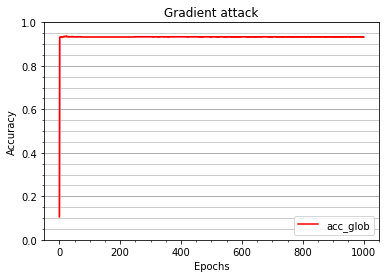

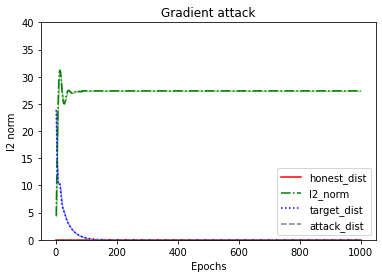

In [ ]:
# gradient attack
plot_metrics([hist_gradient], title='Gradient attack', path='gradient_')

### model

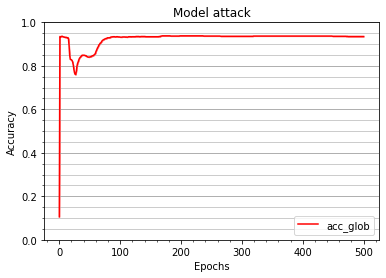

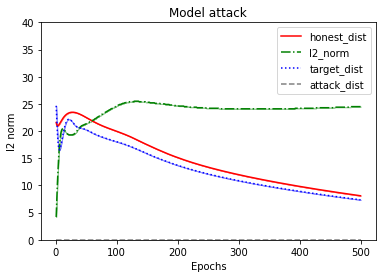

In [ ]:
# model attack
plot_metrics([hist_model], title='Model attack', path='model_')

### data

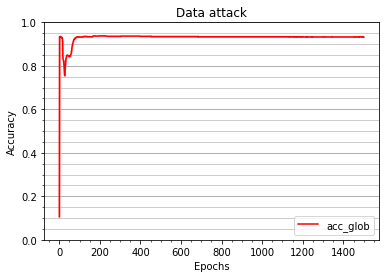

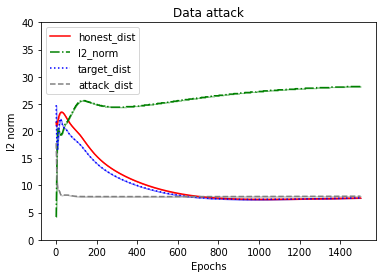

In [ ]:
# data attack
plot_metrics([hist_data], title='Data attack', path='data_')